# Spectral sensitivity of the light logger

## Jeti data
--------------------------------

### 1. Spectral irradiance

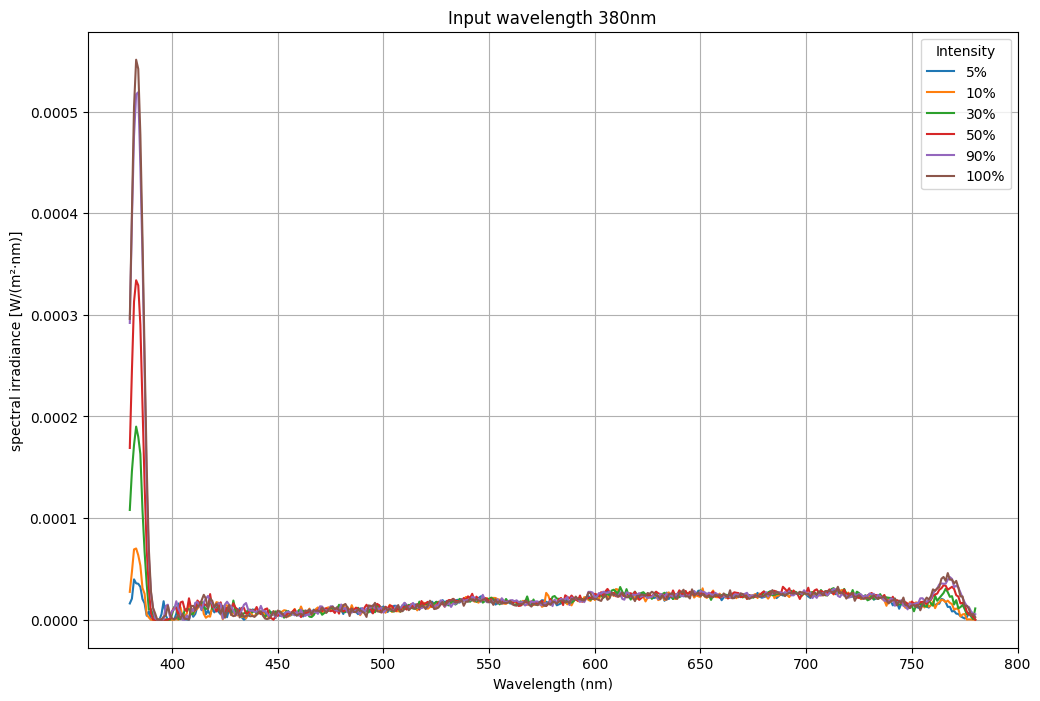

<Figure size 640x480 with 0 Axes>

In [6]:
#-------------------------------------------
#           spectral plot
#------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

csv_file_path = r'spectral_Jeti_all intensities.csv'
data = pd.read_csv(csv_file_path, sep=';', decimal=',')

data = data[['intensity', 'wavelength', '400nm']]    # Select relevant columns
grouped = data.groupby('intensity')                  # Grouping by intensity

plt.figure(figsize=(12, 8))
for intensity, group in grouped:
    plt.plot(group['wavelength'], group['380nm'], label=f'{intensity}%')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral irradiance [W/(m²·nm)]')
plt.title('Input wavelength 380nm')
plt.legend(title='Intensity')
plt.grid(True)
plt.show()


### 2. Total irradiance vs. intensity

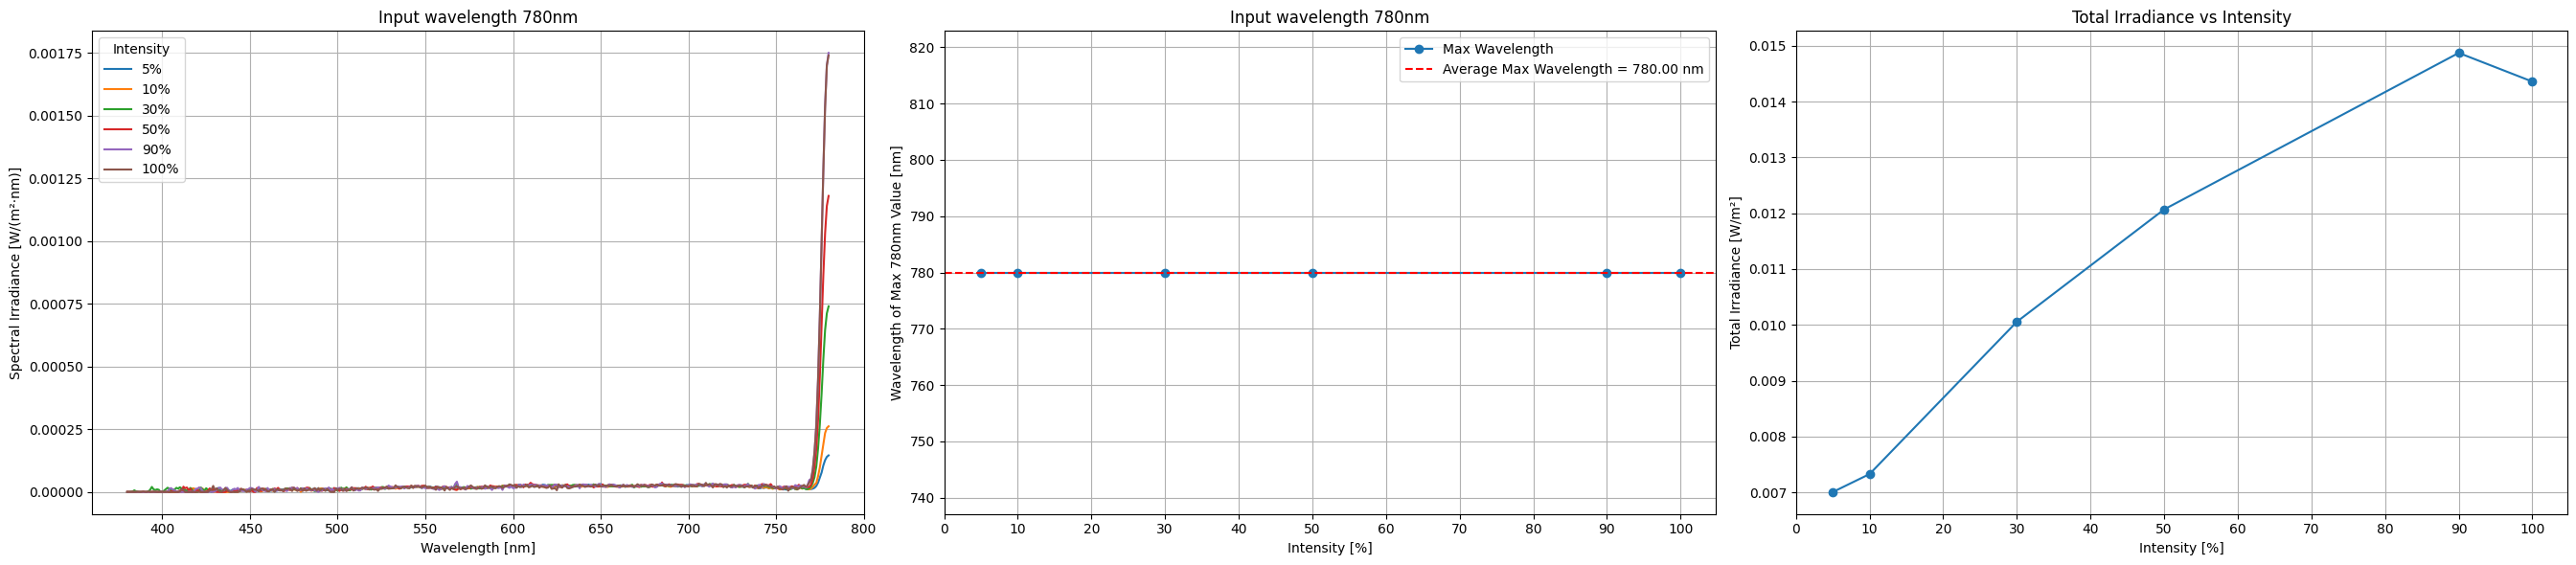

In [178]:
# -----------------------------------------------
# 3 plots - spectral, max. wavelength, irradiance
# ------------------------------------------------

# SIMPSONS INTEGRAL is being used! --> more precise than trapezoidal rule

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps

# Specify the path to the CSV file
csv_file_path = r'spectral_Jeti_all intensities.csv'  

# Read the CSV file
data = pd.read_csv(csv_file_path, sep=';', decimal=',')

# Select relevant columns  
data = data[['intensity', 'wavelength', '780nm']]

# Group data by intensity
grouped = data.groupby('intensity')

# Plot curves without logarithm
plt.figure(figsize=(27, 6))

plt.subplot(1, 3, 1)  # First plot on the left side
for intensity, group in grouped:
    plt.plot(group['wavelength'], group['780nm'], label=f'{intensity}%')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Spectral Irradiance [W/(m²·nm)]') 
plt.title('Input wavelength 780nm')
plt.legend(title='Intensity')
plt.grid(True)

# Second plot - Wavelength of the maximum 780nm value for each intensity
max_wavelengths = data.loc[data.groupby('intensity')['780nm'].idxmax()].reset_index(drop=True)

# Calculate the average of maximum wavelengths
average_max_wavelength = max_wavelengths['wavelength'].mean()

plt.subplot(1, 3, 2)  # Second plot in the middle
plt.plot(max_wavelengths['intensity'], max_wavelengths['wavelength'], 'o-', label='Max Wavelength')
plt.axhline(y=average_max_wavelength, color='r', linestyle='--', label=f'Average Max Wavelength = {average_max_wavelength:.2f} nm')
plt.xlabel('Intensity [%]')
plt.ylabel('Wavelength of Max 780nm Value [nm]')
plt.title('Input wavelength 780nm')
plt.grid(True)

# Set x-axis ticks in 10-unit steps
plt.xticks(range(0, int(max_wavelengths['intensity'].max()) + 10, 10))

# Set y-axis ticks in 5-unit steps starting from 400
#plt.yticks(np.arange(400, max_wavelengths['wavelength'].max() + 5, 5))

# Add legend with average max wavelength
plt.legend()

# Third plot - Total irradiance for each intensity
total_irradiance = []
intensity_levels = []

plt.subplot(1, 3, 3)  # Third plot on the right side
for intensity, group in grouped:
    area = simps(group['780nm'], group['wavelength'])
    total_irradiance.append(area)
    intensity_levels.append(intensity)
plt.plot(intensity_levels, total_irradiance, 'o-')
plt.xlabel('Intensity [%]')
plt.ylabel('Total Irradiance [W/m²]')
plt.title('Total Irradiance vs Intensity')
plt.grid(True)
# Set x-axis ticks in 10-unit steps
plt.xticks(range(0, int(max_wavelengths['intensity'].max()) + 10, 10))

# Adjust layout and display
plt.tight_layout()
plt.savefig('spec_jeti_780nm_3plots.png', format='png', bbox_inches='tight')
plt.show()


## Merging csv files
-------------

### 1. Filtering and saving a specific data

In [192]:
!pip install openpyxl # Install openpyxl if it's not already installed

import pandas as pd
from scipy.integrate import simps

csv_file_path = r'spectral_Jeti_all intensities.csv' # Specify the path to the CSV file + replace with the path to your CSV file
data = pd.read_csv(csv_file_path, sep=';', decimal=',')

intensity_5_data = data[data['intensity'] == 5]   # Filter the data for ONLY intensity = 5
areas = {}                                        # Initialize a dictionary to store the area under the curve for each wavelength

# Iterate over each column from 380nm to 780nm
for column in intensity_5_data.columns[2:]:
    area_under_curve = simps(intensity_5_data[column], intensity_5_data['wavelength'])
    areas[column] = area_under_curve

results_df = pd.DataFrame(list(areas.items()), columns=['wavelength', 'total irradiance - 5%'])  # Convert the dictionary to a DataFrame

excel_file_path = r'total_irradiance_jeti_5%.xlsx'  # Specify the path to save the Excel file + replace with the desired path to your Excel file
results_df.to_excel(excel_file_path, index=False)   # Save DataFrame to Excel file

print(f'Results saved to {excel_file_path}')


Results saved to C:\Users\bkaya\Desktop\MPI\Thesis\Field trials\spectral_Jeti\csv_spectral\total_irradiance_jeti_5%.xlsx


### 2. Sorting and saving multiple data

In [193]:
# ------------------------------
# save results of total irradiance
# ------------------------------

import pandas as pd
from scipy.integrate import simps

# Specify the path to the CSV file
csv_file_path = r'spectral_Jeti_all intensities.csv'  

# Read the CSV file
data = pd.read_csv(csv_file_path, sep=';', decimal=',')

# Define the intensities of interest
intensities = [5, 10, 30, 50, 90, 100]

# Initialize a dictionary to store DataFrames for each intensity
areas_dict = {}

# Iterate over each intensity and calculate the area under the curve for each wavelength column
for intensity in intensities:
    intensity_data = data[data['intensity'] == intensity]
    areas = {}
    for column in intensity_data.columns[2:]:
        area_under_curve = simps(intensity_data[column], intensity_data['wavelength'])
        areas[column] = area_under_curve
    areas_dict[intensity] = pd.DataFrame(list(areas.items()), columns=['Wavelength', f'total_irradiance_{intensity}%'])

# Merge all the DataFrames on 'Wavelength'
result_df = areas_dict[5]
for intensity in intensities[1:]:
    result_df = result_df.merge(areas_dict[intensity], on='Wavelength')

# Specify the path to save the Excel file
excel_file_path = r'total_irradiance.xlsx'  # Replace with the desired path to your Excel file

# Save the DataFrame to an Excel file
result_df.to_excel(excel_file_path, index=False)

print(f'Results saved to {excel_file_path}')


Results saved to C:\Users\bkaya\Desktop\MPI\Thesis\Field trials\spectral_Jeti\csv_spectral\total_irradiance_jeti_all.xlsx


## Sensor data
----------

### 1. Normalized sensor output

Work with these plots to determine max. value of all wavelengths and then what irradiance value corresponds to 50% sensor response 

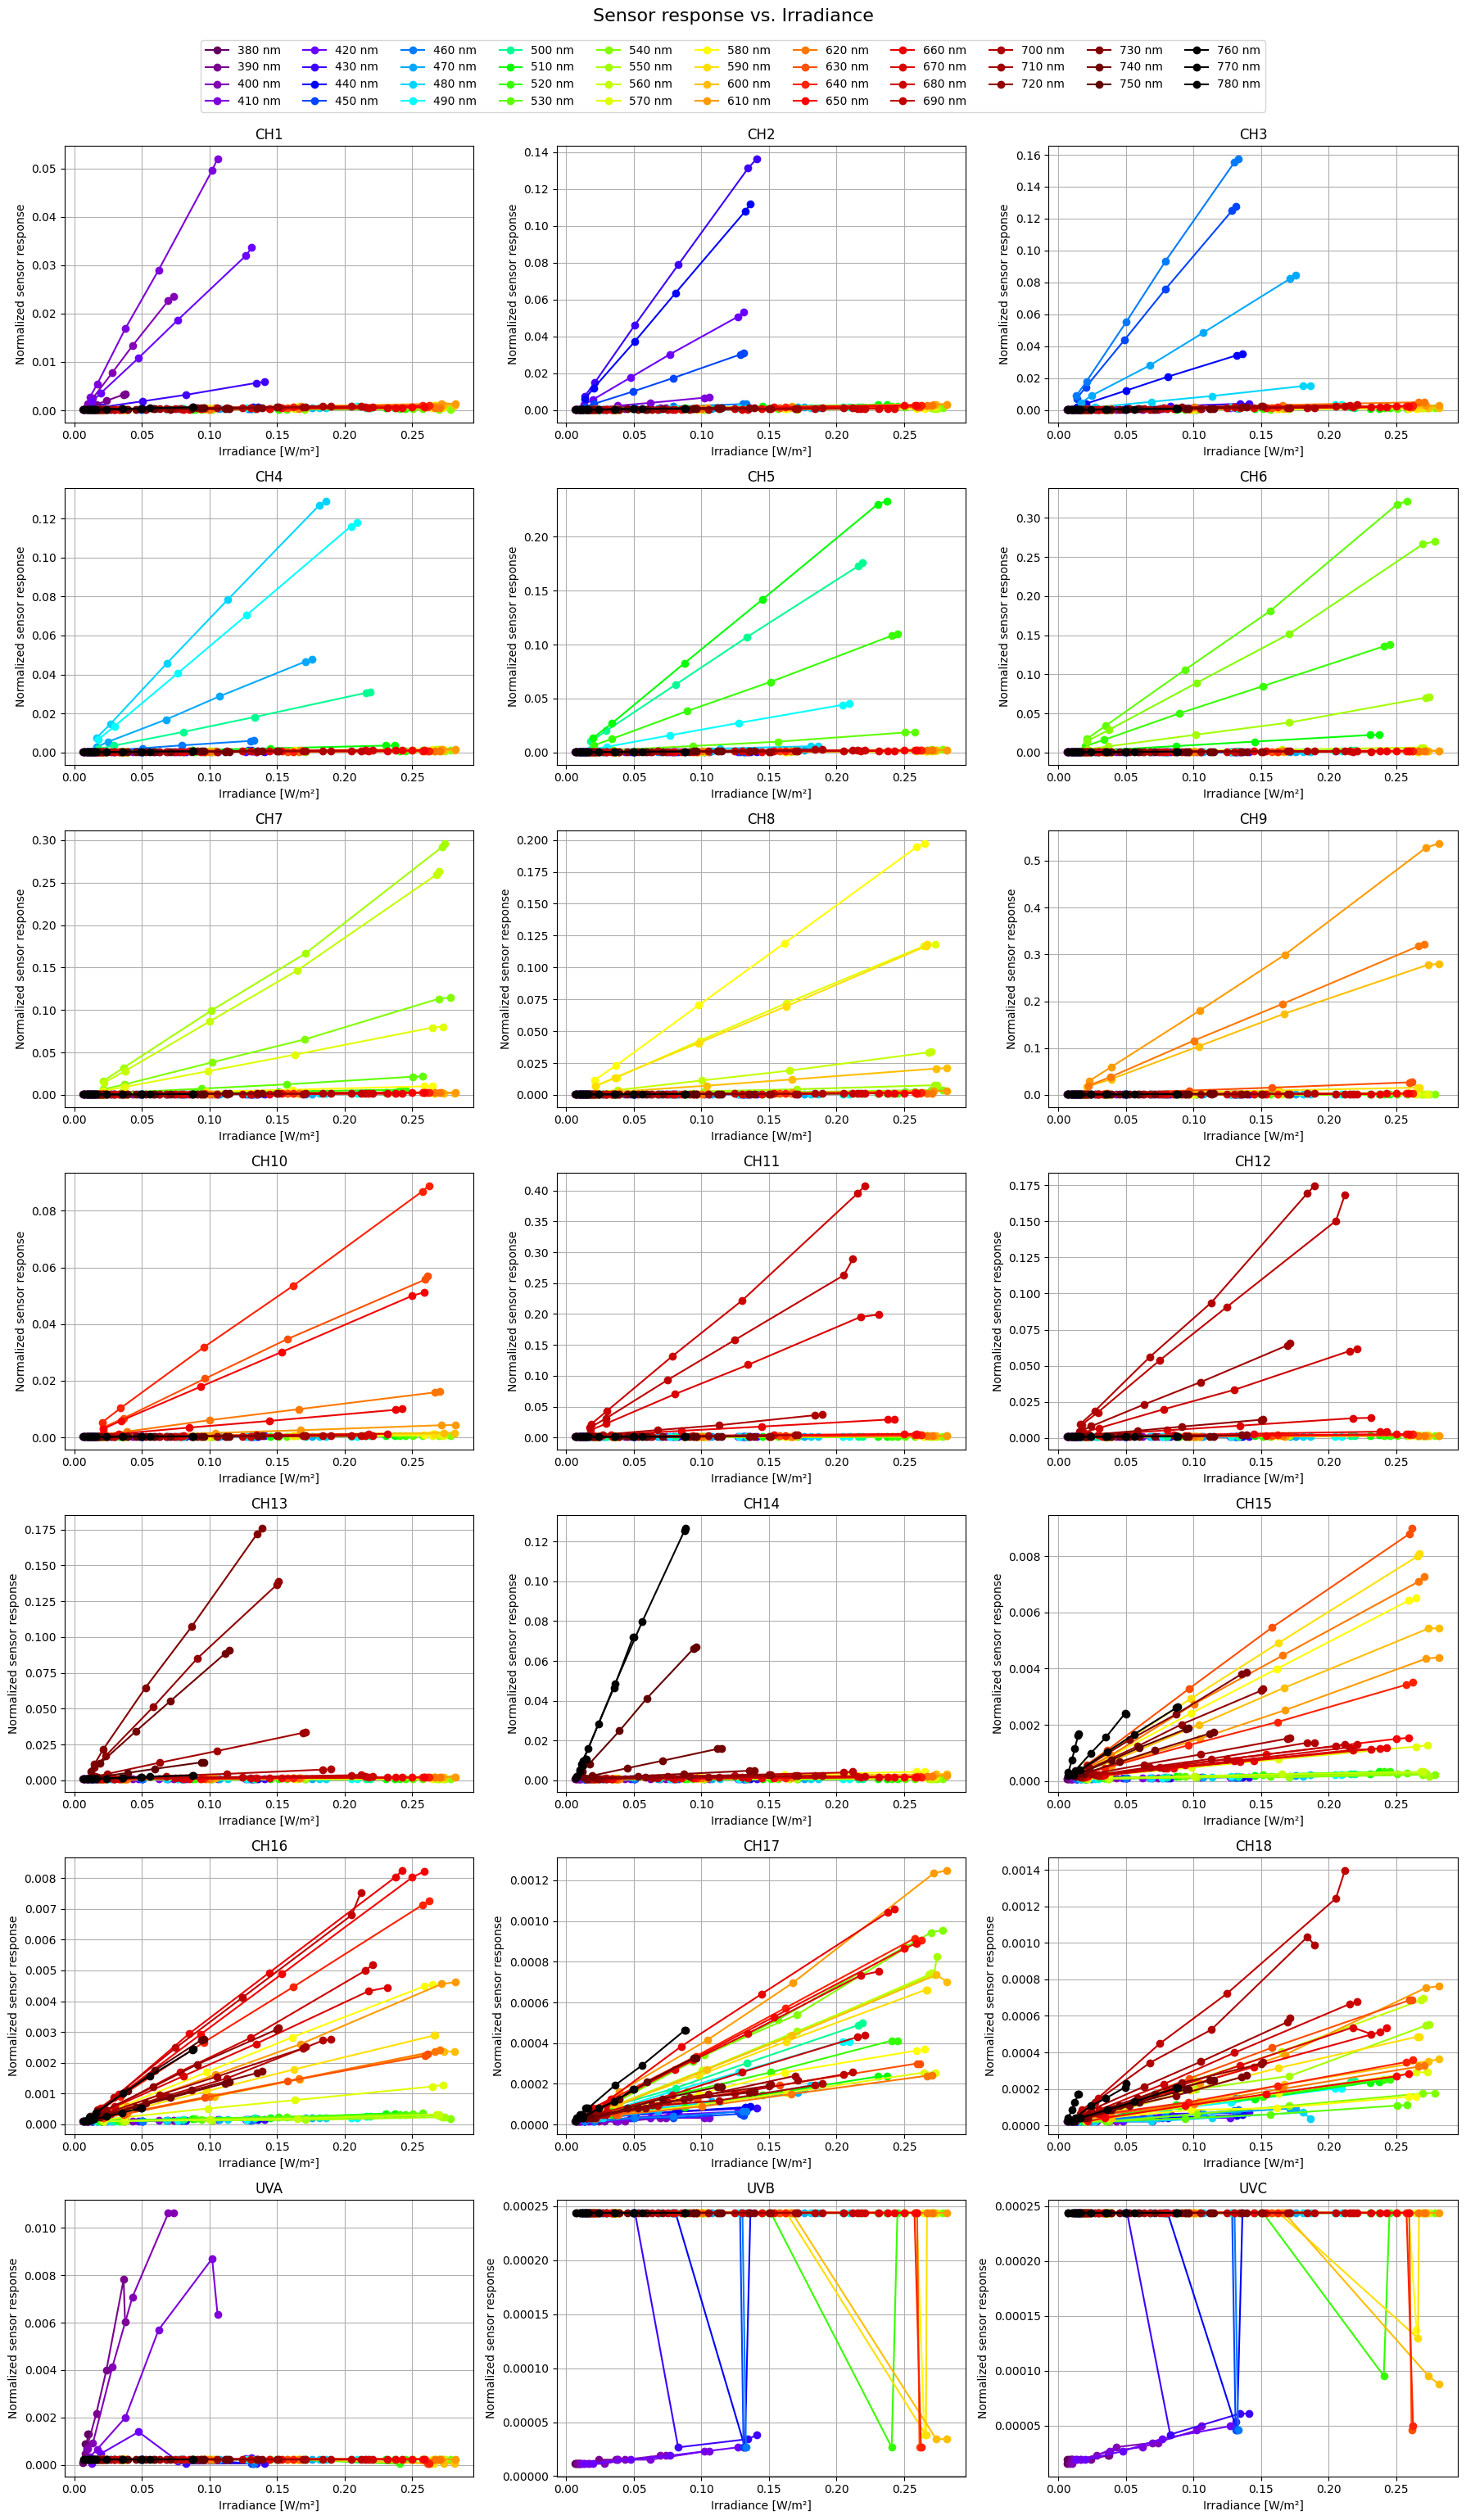

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# adjust gain values for ONLY VIS and IR channels (worked with old QT version)
def adjust_gain(gain):
    if gain == 0:
        return 1
    elif gain == 1:
        return 3.7
    elif gain == 2:
        return 16
    elif gain == 3:
        return 64
    else:
        return gain

# adjust integration time values for ONLY VIS and IR channels 
def adjust_integration_time(time):
    return (time + 1) * 2.78

# function to transform change color of curves according to their wavelengths
def wavelength_to_rgb(wavelength):
    gamma = 0.8
    intensity_max = 255
    factor = 0.0
    R = G = B = 0

    if 380 <= wavelength <= 440:
        R = -(wavelength - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif 440 < wavelength <= 490:
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif 490 < wavelength <= 510:
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif 510 < wavelength <= 580:
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif 580 < wavelength <= 645:
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif 645 < wavelength <= 750:
        R = 1.0
        G = 0.0
        B = 0.0

    if 380 <= wavelength <= 420:
        factor = 0.3 + 0.7 * (wavelength - 380) / (420 - 380)
    elif 420 < wavelength <= 645:
        factor = 1.0
    elif 645 <= wavelength <= 750:
        factor = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)

    R = round(intensity_max * (R * factor) ** gamma)
    G = round(intensity_max * (G * factor) ** gamma)
    B = round(intensity_max * (B * factor) ** gamma)

    return (R / 255, G / 255, B / 255)

# Einlesen der total_irradiance CSV-Datei
irradiance_df = pd.read_csv('total_irradiance.csv', delimiter=';', decimal=',')

# List of irradiance values and corresponding filenames
irradiance_columns = [
    'Total irradiance - 5%',
    'Total irradiance - 10%',
    'Total irradiance - 30%',
    'Total irradiance - 50%',
    'Total irradiance - 90%',
    'Total irradiance - 100%'
]
filenames = [f'spectral_sensor_{irradiance}%' for irradiance in [5, 10, 30, 50, 90, 100]]
channels = [f'c_CH{i}' for i in range(1, 19)] + ['UVA', 'UVB', 'UVC']

# Dictionary zur Speicherung der Daten für jede Wellenlänge und jeden Kanal
data_dict = {channel: {} for channel in channels}

# Einlesen der CSV-Dateien und Berechnen der benötigten Werte
for filename in filenames:
    df = pd.read_csv(filename + '.csv')
    
    for _, row in df.iterrows():
        wavelength = row['input_wavelength']
        for channel in channels:
            if channel.startswith('c_CH'):
                adjusted_gain = adjust_gain(row['VISgain'])
                adjusted_integration_time = adjust_integration_time(row['VISintegrationtime'])
                corrected_value = row[channel] / (adjusted_gain * adjusted_integration_time)
            else:  # Für UVA, UVB, UVC
                gain = row['gain']
                integration_time = row['integrationtime']
                corrected_value = row[channel] / (gain * integration_time)
            
            if wavelength not in data_dict[channel]:
                data_dict[channel][wavelength] = []
            data_dict[channel][wavelength].append(corrected_value)

# Erstellen der Plots in einem Grid
fig, axes = plt.subplots(7, 3, figsize=(18, 32))
axes = axes.flatten()

# Erstellen eines leeren Sets, um Duplikate zu vermeiden
lines = []
labels = []

for i, channel in enumerate(channels):
    ax = axes[i]
    for wavelength, values in data_dict[channel].items():
        color = wavelength_to_rgb(wavelength)
        irradiance_values = irradiance_df.loc[irradiance_df['Wavelength'] == wavelength, irradiance_columns].values.flatten()
        line, = ax.plot(
            irradiance_values,  # x-Werte (Bestrahlungsstärke)
            values,             # y-Werte
            label=f'Wavelength {wavelength} nm',
            color=color,
            marker='o'
        )
        # Nur einmal die Legenden-Labels hinzufügen
        if wavelength not in labels:
            lines.append(line)
            labels.append(wavelength)
    ax.set_title(f'CH{i+1}' if channel.startswith('c_CH') else channel)  # Titel der Plots anpassen
    ax.set_xlabel('Irradiance [W/m²]')
    ax.set_ylabel('Normalized sensor response')
    ax.grid(True)

fig.legend(handles=lines, labels=[f'{wavelength} nm' for wavelength in labels], loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=11)
fig.suptitle('Sensor response vs. Irradiance', fontsize=16, y=0.96)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Platz für die Legende oben freilassen
plt.show()



### 2. Spectral sensitivity 

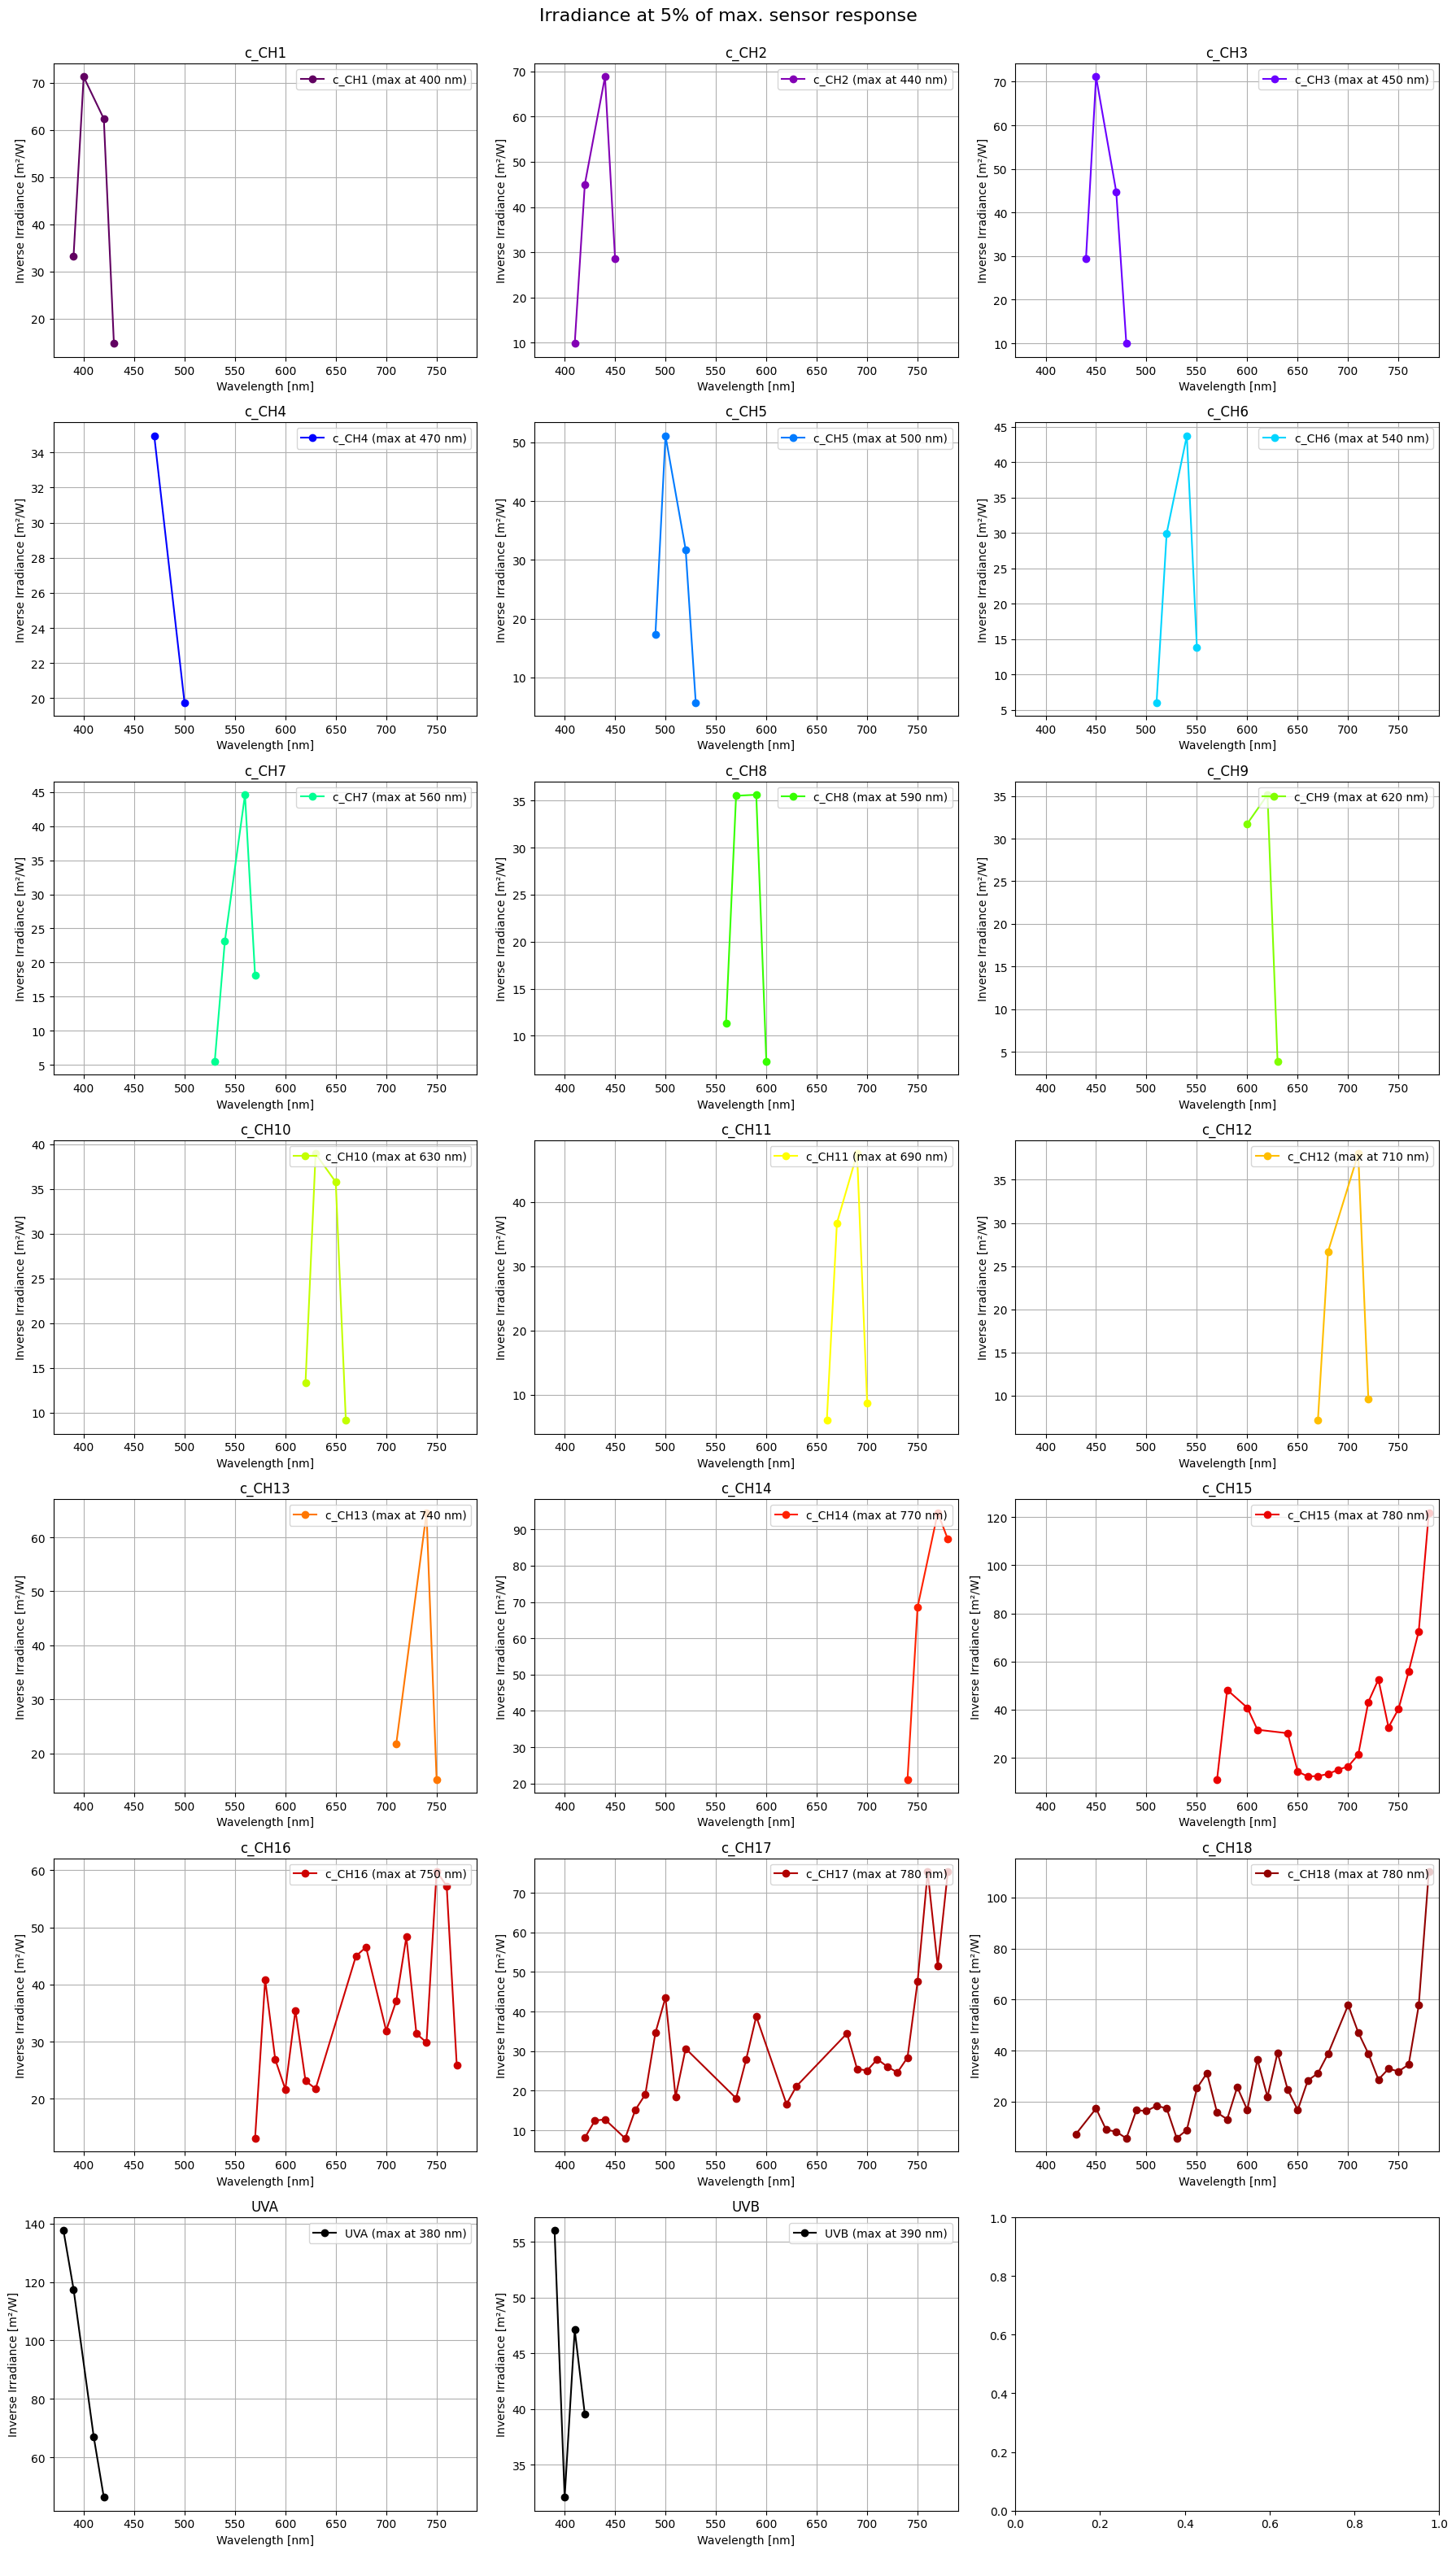

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# adjust gain values for ONLY VIS and IR channels (worked with old QT version)
def adjust_gain(gain):
    if gain == 0:
        return 1
    elif gain == 1:
        return 3.7
    elif gain == 2:
        return 16
    elif gain == 3:
        return 64
    else:
        return gain

# adjust integration time values for ONLY VIS and IR channels 
def adjust_integration_time(time):
    return (time + 1) * 2.78

# function to transform change color of curves according to their wavelengths
def wavelength_to_rgb(wavelength):
    gamma = 0.8
    intensity_max = 255
    factor = 0.0
    R = G = B = 0

    if 380 <= wavelength <= 440:
        R = -(wavelength - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif 440 < wavelength <= 490:
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif 490 < wavelength <= 510:
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif 510 < wavelength <= 580:
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif 580 < wavelength <= 645:
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif 645 < wavelength <= 750:
        R = 1.0
        G = 0.0
        B = 0.0

    if 380 <= wavelength <= 420:
        factor = 0.3 + 0.7 * (wavelength - 380) / (420 - 380)
    elif 420 < wavelength <= 645:
        factor = 1.0
    elif 645 <= wavelength <= 750:
        factor = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)

    R = round(intensity_max * (R * factor) ** gamma)
    G = round(intensity_max * (G * factor) ** gamma)
    B = round(intensity_max * (B * factor) ** gamma)

    return (R / 255, G / 255, B / 255)

# Einlesen der total_irradiance CSV-Datei
irradiance_df = pd.read_csv('total_irradiance.csv', delimiter=';', decimal=',')

# List of irradiance values and corresponding filenames
irradiance_columns = [
    'Total irradiance - 5%',
    'Total irradiance - 10%',
    'Total irradiance - 30%',
    'Total irradiance - 50%',
    'Total irradiance - 90%',
    'Total irradiance - 100%'
]
filenames = [f'spectral_sensor_{irradiance}%' for irradiance in [5, 10, 30, 50, 90, 100]]
channels = [f'c_CH{i}' for i in range(1, 19)] + ['UVA', 'UVB', 'UVC']

# Dictionary zur Speicherung der Daten für jede Wellenlänge und jeden Kanal
data_dict = {channel: {} for channel in channels}

# Einlesen der CSV-Dateien und Berechnen der benötigten Werte
for filename in filenames:
    df = pd.read_csv(filename + '.csv')
    
    for _, row in df.iterrows():
        wavelength = row['input_wavelength']
        for channel in channels:
            if channel.startswith('c_CH'):
                adjusted_gain = adjust_gain(row['VISgain'])
                adjusted_integration_time = adjust_integration_time(row['VISintegrationtime'])
                corrected_value = row[channel] / (adjusted_gain * adjusted_integration_time)
            else:  # Für UVA, UVB, UVC
                gain = row['gain']
                integration_time = row['integrationtime']
                corrected_value = row[channel] / (gain * integration_time)
            
            if wavelength not in data_dict[channel]:
                data_dict[channel][wavelength] = []
            data_dict[channel][wavelength].append(corrected_value)

# Bestimmen der maximalen Sensorantwort für jeden Kanal
max_responses = {channel: max([max(values) for values in data_dict[channel].values()]) for channel in channels}

# Berechnen der Irradiance-Werte bei 5% der maximalen Sensorantwort mit linearer Interpolation
five_percent_responses = {channel: max_response * 0.05 for channel, max_response in max_responses.items()}
five_percent_irradiance = {channel: [] for channel in channels}

for channel in channels:
    five_percent = five_percent_responses[channel]
    for wavelength, values in data_dict[channel].items():
        for i in range(len(values) - 1):
            if values[i] <= five_percent <= values[i + 1]:
                x0, x1 = values[i], values[i + 1]
                y0 = irradiance_df.loc[irradiance_df['Wavelength'] == wavelength, irradiance_columns].values.flatten()[i]
                y1 = irradiance_df.loc[irradiance_df['Wavelength'] == wavelength, irradiance_columns].values.flatten()[i + 1]
                # Lineare Interpolation
                interpolated_irradiance = y0 + (five_percent - x0) * (y1 - y0) / (x1 - x0)
                five_percent_irradiance[channel].append((wavelength, interpolated_irradiance))
                break

# Überprüfen, ob Daten für UVC vorhanden sind und debuggen
# print(f'UVC Data: {five_percent_irradiance["UVC"]}')
# if not five_percent_irradiance["UVC"]:
#    for filename in filenames:
#        df = pd.read_csv(filename + '.csv')
#        print(f'Checking {filename} for UVC data...')
#        print(df[['input_wavelength', 'UVC']])

# Definieren der Farben für die Kanäle
channel_colors = {f'c_CH{i}': wavelength_to_rgb(380 + (i - 1) * 20) for i in range(1, 19)}
channel_colors['UVA'] = wavelength_to_rgb(200)
channel_colors['UVB'] = wavelength_to_rgb(280)
channel_colors['UVC'] = wavelength_to_rgb(315)

# Plotten der Irradiance-Werte bei 5% der maximalen Sensorantwort in einem Grid
fig, axes = plt.subplots(7, 3, figsize=(18, 32))
axes = axes.flatten()

for i, channel in enumerate(channels):
    ax = axes[i]
    wavelengths = [item[0] for item in five_percent_irradiance[channel]]
    irradiances = [item[1] for item in five_percent_irradiance[channel]]
    
    inverse_irradiances = [1/irr for irr in irradiances] 

    if irradiances:  # Überprüfen, ob die Liste der Irradiance-Werte nicht leer ist
        # Finden des minimalen Irradiance-Werts und der entsprechenden Wellenlänge
        max_irradiance_index = np.argmax(inverse_irradiances)
        max_irradiance_wavelength = wavelengths[max_irradiance_index]
        
        ax.plot(wavelengths, inverse_irradiances, label=f'{channel} (max at {max_irradiance_wavelength} nm)', color=channel_colors[channel], marker='o')
        ax.set_title(channel)
        ax.set_xlabel('Wavelength [nm]')
        ax.set_ylabel('Inverse Irradiance [m²/W]')
        ax.set_xlim(370, 790)  # Set the x-axis limits to 380 nm to 780 nm
        ax.grid(True)
        ax.legend(loc='upper right')

# Entferne die leeren Plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Platz für die Legende oben freilassen
plt.suptitle('Irradiance at 5% of max. sensor response', fontsize=16, y=0.98)

plt.show()
